In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
import copy
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

In [3]:
df.shape

(144, 1)

Print top 5 rows

In [4]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [5]:
def plot_timeseries(df):
    df.plot()
    plt.show()

Plot the timeseries from above

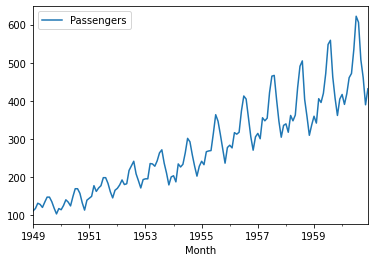

In [6]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [7]:
# rolling mean
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()

# rolling mean
rolling = df.rolling(window=3)
rolling_std = rolling.std()

Plot two timeseries:
- with rolling mean 
- with rolling std

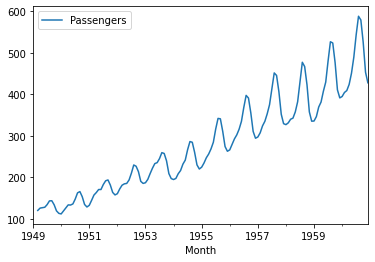

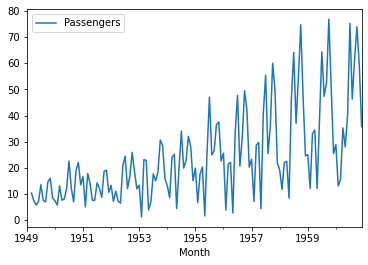

In [8]:
plot_timeseries(rolling_mean)
plot_timeseries(rolling_std)

Test the stationarity of all timeseries

In [9]:
res = adfuller(df)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: 0.815369
p-value: 0.991880


In [10]:
res = adfuller(rolling_mean.dropna())
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: 0.822058
p-value: 0.991984


In [11]:
res = adfuller(rolling_std.dropna())
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: 0.845663
p-value: 0.992339


Transform the original timeseries with logarithm

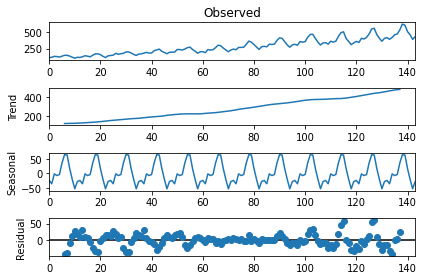

In [12]:
result = seasonal_decompose(list(df['Passengers']), model='additive', period=12)
result.plot()
plt.show()

In [15]:
df_temp = copy.deepcopy(df)
df_temp['res_trend'] = list(result.trend)
df_temp['res_seas'] = list(result.seasonal)
df_temp['res_resid'] = list(result.resid)
df_temp['y'] = df_temp['Passengers']-df_temp['res_seas']
df_temp.dropna(inplace= True)
df_temp.head()

,Passengers,res_trend,res_seas,res_resid,y
Month,,,,,
1949-07-01,148,126.791667,63.830808,-42.622475,84.169192
1949-08-01,148,127.250000,62.823232,-42.073232,85.176768
1949-09-01,136,127.958333,16.520202,-8.478535,119.479798
1949-10-01,119,128.583333,-20.642677,11.059343,139.642677
1949-11-01,104,129.000000,-53.593434,28.593434,157.593434


In [504]:
df_temp['y'] = np.log(df_temp['y'])
df_temp = df_temp.shift(-1) *100
#df_temp = df_temp.shift(-1) 
df_temp = df_temp.diff()
df_temp.dropna(inplace=True)
df_temp.head()

,Passengers,res_trend,res_seas,res_resid,y
Month,,,,,
1949-08-01,-1200.0,70.833333,-4630.303030,3359.469697,33.841859
1949-09-01,-1700.0,62.500000,-3716.287879,1953.787879,15.593955
1949-10-01,-1500.0,41.666667,-3295.075758,1753.409091,12.093167
1949-11-01,1400.0,75.000000,2497.348485,-1172.348485,-7.217465
1949-12-01,-300.0,150.000000,387.121212,-837.121212,-4.799778


In [517]:
#df_log = copy.deepcopy(df.iloc[51:])
df_log = copy.deepcopy(df)
df_log['Passengers'] = np.log(df_log['Passengers'])
#df_log = df_log.shift(-1)/df
#df_log = df_log.shift(-1) *100
df_log = df_log.diff()
df_log = df_log.diff()
df_log = df_log.diff()
df_log.dropna(inplace=True)
df_log

,Passengers
Month,
1949-04-01,-0.195038
1949-05-01,0.094074
1949-06-01,0.214538
1949-07-01,-0.191053
1949-08-01,-0.074391
...,...
1960-08-01,-0.202119
1960-09-01,0.026395
1960-10-01,0.229654


Plot transformed timeseries

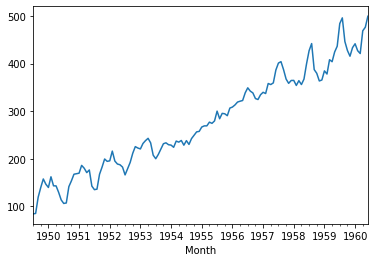

In [16]:
plot_timeseries(df_temp['y'])

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [17]:
res = adfuller(df_temp['y'])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: 0.927735
p-value: 0.993442


Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


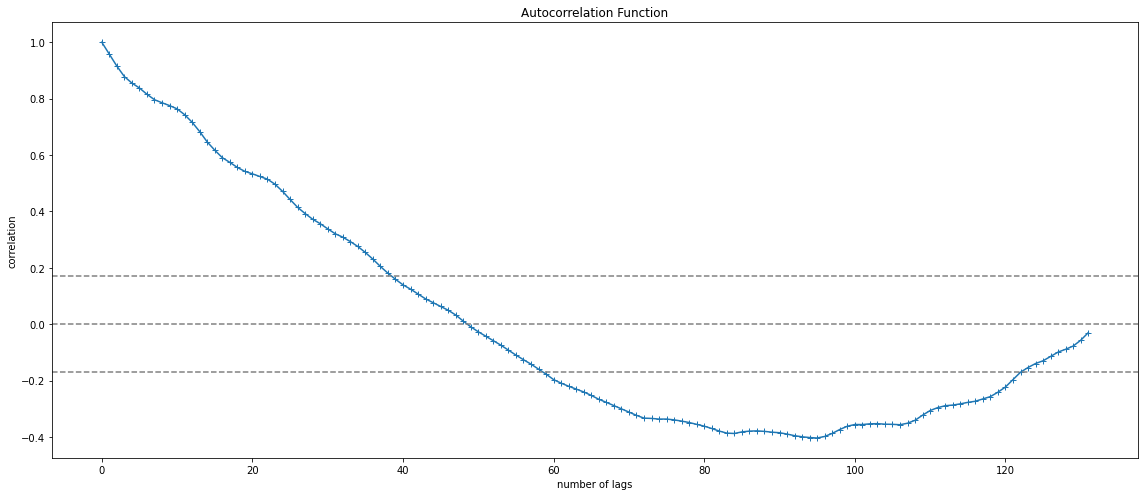

In [18]:
lag_acf = acf(df_temp['y'], nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_temp['y'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_temp['y'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

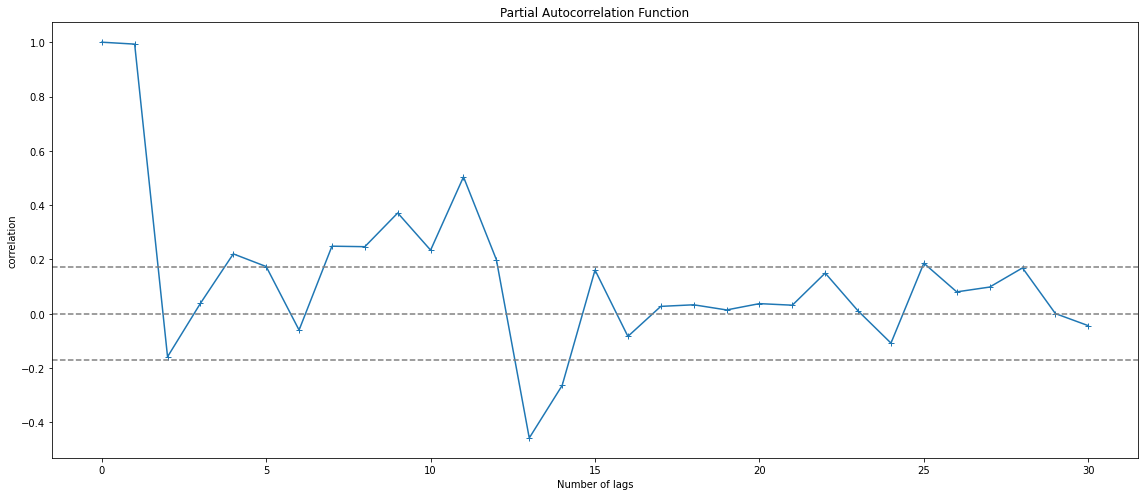

In [19]:
#calling partial correlation function
lag_pacf = pacf(df_temp['y'], nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_temp['y'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_temp['y'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

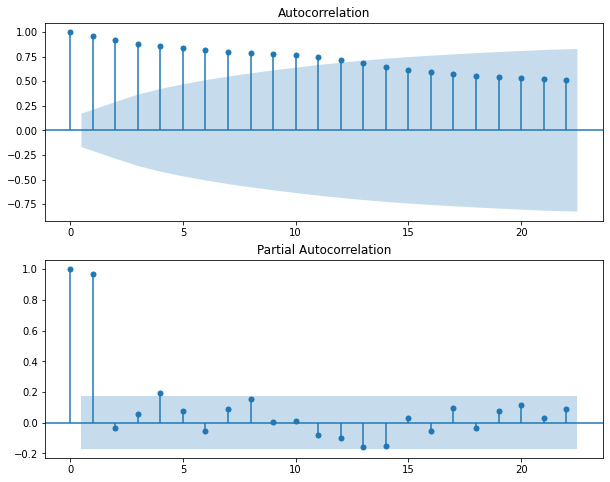

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(df_temp['y'], ax=plt.gca())
plt.subplot(212)
plot_pacf(df_temp['y'], ax=plt.gca())
plt.show()

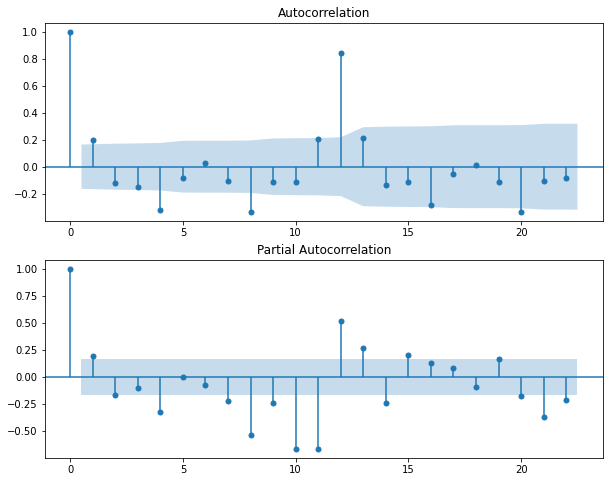

In [335]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(df_log, ax=plt.gca())
plt.subplot(212)
plot_pacf(df_log, ax=plt.gca())
plt.show()

Plot the predictions (not transformed to the original scale)

In [295]:
# model = ARIMA(df_log, order=(1,1,1))
# model_fit = model.fit(disp=0)

In [21]:
X = df_temp['y'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs), '\n')
error = mean_squared_error(test, predictions)

Test MSE: 404.781


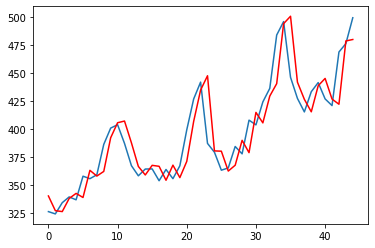

In [22]:
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Plot the predictions (transformed to the original scale)

In [338]:
X = df_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs), '\n')
error = mean_squared_error(test, predictions)

Test MSE: 121.536


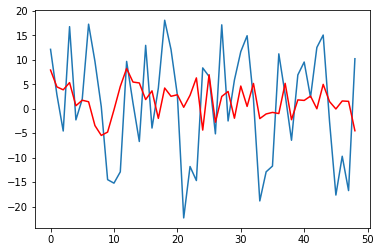

In [339]:
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Plot the predictions for the next 10 years

In [56]:
df_temp['y']

Month
1949-07-01     84.169192
1949-08-01     85.176768
1949-09-01    119.479798
1949-10-01    139.642677
1949-11-01    157.593434
                 ...    
1960-02-01    427.188131
1960-03-01    421.241162
1960-04-01    469.036616
1960-05-01    476.506313
1960-06-01    499.597222
Name: y, Length: 132, dtype: float64

In [79]:
model = ARIMA(df_temp['y'], order=(1,1,0))
model_fit = model.fit()
#model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [80]:
import datetime as dt
start_index = dt.datetime(1960, 6, 1)
end_index = dt.datetime(1970, 6, 1)
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

In [82]:
forecast = forecast + result.seasonal[-121:] 

In [83]:
#result.seasonal[-18:]

In [84]:
forecast.shape

(121,)

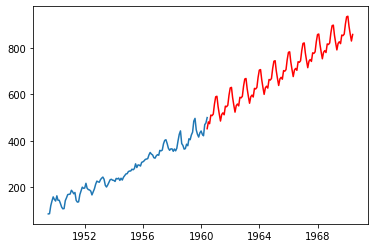

In [85]:
# df.plot()
# plt.show()

fig, ax = plt.subplots()
ax.plot(df_temp['y'], label="Data")
ax.plot(forecast, color='red', label="True")

#ax.plot(np.hstack((x1, x1n)), np.hstack((ypred, ynewpred)), 'r', label="OLS prediction")
#ax.legend(loc="best");